In [9]:
import torch
import torch.nn as nn
from torch.optim import SGD, Adam
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
import csv
import os

main_directory = '/home/kvadner/Fault Detection/LSTM-Fault-Detection'
data_folder = 'data'  # Adjust if your data folder has a different path
model_name = 'Stacked-LSTM'
model_folder = os.path.join(main_directory, 'model', model_name)

# Set device for model training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [10]:
# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, num_features, num_classes, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=num_features, hidden_size=hidden_size, 
                            num_layers=num_layers, batch_first=True)
        self.label_fc = nn.Linear(num_classes, hidden_size)
        self.output_fc = nn.Linear(hidden_size, num_features)
    
    def forward(self, x, labels):
        lstm_out, _ = self.lstm(x)
        label_out = self.label_fc(labels)
        label_out = label_out.unsqueeze(1).repeat(1, lstm_out.size(1), 1)
        combined = lstm_out + label_out
        out = self.output_fc(combined)
        return out

# CNN-LSTM Model
class CNNLSTMModel(nn.Module):
    def __init__(self, num_features, num_classes, hidden_size, num_layers):
        super(CNNLSTMModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=num_features, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(input_size=64, hidden_size=hidden_size, 
                            num_layers=num_layers, batch_first=True)
        self.label_fc = nn.Linear(num_classes, hidden_size)
        self.output_fc = nn.Linear(hidden_size, num_features)
    
    def forward(self, x, labels):
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = x.permute(0, 2, 1)
        lstm_out, _ = self.lstm(x)
        label_out = self.label_fc(labels)
        label_out = label_out.unsqueeze(1).repeat(1, lstm_out.size(1), 1)
        combined = lstm_out + label_out
        out = self.output_fc(combined)
        return out

In [11]:
class ModifiedSeq2SeqLSTM(nn.Module):
    def __init__(self, num_features, hidden_size, num_classes, n_steps_in, n_steps_out):
        super(ModifiedSeq2SeqLSTM, self).__init__()

        self.n_steps_out = n_steps_out
        self.encoder_lstm = nn.LSTM(input_size=num_features + num_classes, 
                                    hidden_size=hidden_size, 
                                    batch_first=True)
        self.repeat = lambda x: x.repeat(1, n_steps_out, 1)
        self.decoder_lstm = nn.LSTM(input_size=hidden_size, 
                                    hidden_size=hidden_size, 
                                    batch_first=True, 
                                    return_sequences=True)
        self.time_distributed = nn.Linear(hidden_size, num_features)

    def forward(self, x, labels):
        # Expand labels to match sequence length and concatenate with input
        labels_expanded = labels.unsqueeze(1).repeat(1, x.size(1), 1)
        x_combined = torch.cat((x, labels_expanded), 2)

        # Encoding
        encoded, _ = self.encoder_lstm(x_combined)
        repeated = self.repeat(encoded[:, -1, :])
        decoded, _ = self.decoder_lstm(repeated)
        out = self.time_distributed(decoded)

        return out

In [12]:
class ModifiedSequentialLSTM(nn.Module):
    def __init__(self, num_features, hidden_size, num_classes, n_steps_in, n_steps_out):
        super(ModifiedSequentialLSTM, self).__init__()
        
        self.lstm1 = nn.LSTM(input_size=num_features + num_classes, hidden_size=hidden_size, 
                             batch_first=True, return_sequences=True)
        self.lstm2 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, 
                             batch_first=True)
        self.dense = nn.Linear(hidden_size, n_steps_out)

    def forward(self, x, labels):
        # Expand labels to match sequence length and concatenate with input
        labels_expanded = labels.unsqueeze(1).repeat(1, x.size(1), 1)
        x_combined = torch.cat((x, labels_expanded), 2)

        # Process through LSTM layers
        x, _ = self.lstm1(x_combined)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]
        out = self.dense(x)
        return out

In [13]:
# Load data
X_data = np.load(os.path.join(main_directory, data_folder, 'X_data.npy'))
maneuver_labels = np.load(os.path.join(main_directory, data_folder, 'maneuver_labels.npy'))
Y_data = np.load(os.path.join(main_directory, data_folder, 'Y_data.npy'))

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_data, dtype=torch.float32)
maneuver_labels_tensor = torch.tensor(maneuver_labels, dtype=torch.float32)
Y_tensor = torch.tensor(Y_data, dtype=torch.float32)


In [14]:
# Split data into training and test sets
X_train, X_test, labels_train, labels_test, Y_train, Y_test = train_test_split(
    X_tensor, maneuver_labels_tensor, Y_tensor, test_size=0.2, random_state=42)

# Create DataLoader for training and test sets
train_dataset = TensorDataset(X_train, labels_train, Y_train)
test_dataset = TensorDataset(X_test, labels_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=120, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=120, shuffle=False)


In [15]:
def train_model(model, train_loader, test_loader, epochs, learning_rate):
    criterion = nn.MSELoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    #optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)  # Using SGD with momentum
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

    train_losses, test_losses = [], []
    rmse_values = []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for X_batch, labels_batch, Y_batch in train_loader:
            X_batch = X_batch.permute(0, 2, 1)
            Y_batch = Y_batch.permute(0, 2, 1)
            
            X_batch, labels_batch, Y_batch = X_batch.to(device), labels_batch.to(device), Y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch, labels_batch)
            loss = criterion(outputs, Y_batch)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        total_test_loss = 0
        
        with torch.no_grad():
            for X, labels, Y in test_loader:
                X = X.permute(0, 2, 1)
                Y = Y.permute(0, 2, 1)
                X, labels, Y = X.to(device), labels.to(device), Y.to(device)
                test_outputs = model(X, labels)
                test_loss = criterion(test_outputs, Y)
                total_test_loss += test_loss.item()

        avg_test_loss = total_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

        # Calculating RMSE
        rmse = np.sqrt(avg_test_loss)
        rmse_values.append(rmse)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, RMSE: {rmse:.4f}')
        scheduler.step(avg_test_loss)

    return model, train_losses, test_losses, rmse_values


In [16]:
# Training the Stacked-LSTM model and obtaining metrics
lstm_model = LSTMModel(num_features=8, num_classes=7, hidden_size=50, num_layers=2)

# Check for multiple GPUs
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    lstm_model = nn.DataParallel(lstm_model)

lstm_model.to(device)

# Training the model (as before)
trained_lstm_model, lstm_train_losses, lstm_test_losses, lstm_rmse = train_model(
    lstm_model, train_loader, test_loader, epochs=100, learning_rate=0.001)

#trained_cnn_lstm_model, cnn_lstm_train_losses, cnn_lstm_test_losses, cnn_lstm_rmse = train_model(
#    cnn_lstm_model, train_loader, test_loader, epochs=100, learning_rate=0.001)

Using 2 GPUs!
Epoch 1/100, Train Loss: 0.1109, Test Loss: 0.0880, RMSE: 0.2966
Epoch 2/100, Train Loss: 0.0854, Test Loss: 0.0844, RMSE: 0.2905
Epoch 3/100, Train Loss: 0.0813, Test Loss: 0.0804, RMSE: 0.2835
Epoch 4/100, Train Loss: 0.0793, Test Loss: 0.0788, RMSE: 0.2808
Epoch 5/100, Train Loss: 0.0780, Test Loss: 0.0781, RMSE: 0.2795
Epoch 6/100, Train Loss: 0.0771, Test Loss: 0.0773, RMSE: 0.2780
Epoch 7/100, Train Loss: 0.0771, Test Loss: 0.0784, RMSE: 0.2799
Epoch 8/100, Train Loss: 0.0767, Test Loss: 0.0767, RMSE: 0.2770
Epoch 9/100, Train Loss: 0.0759, Test Loss: 0.0761, RMSE: 0.2759
Epoch 10/100, Train Loss: 0.0755, Test Loss: 0.0755, RMSE: 0.2747
Epoch 11/100, Train Loss: 0.0751, Test Loss: 0.0754, RMSE: 0.2746
Epoch 12/100, Train Loss: 0.0749, Test Loss: 0.0753, RMSE: 0.2743
Epoch 13/100, Train Loss: 0.0747, Test Loss: 0.0746, RMSE: 0.2731
Epoch 14/100, Train Loss: 0.0744, Test Loss: 0.0744, RMSE: 0.2727
Epoch 15/100, Train Loss: 0.0743, Test Loss: 0.0747, RMSE: 0.2733
Epoch

In [17]:
# Save the trained model
torch.save(trained_lstm_model.state_dict(), os.path.join(main_directory, model_folder, 'lstm_model_100.pth'))

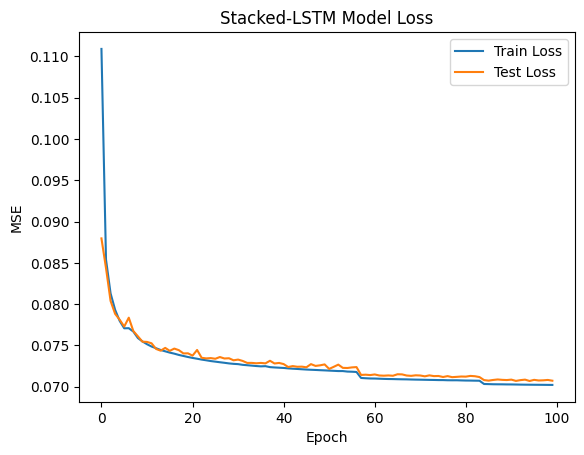

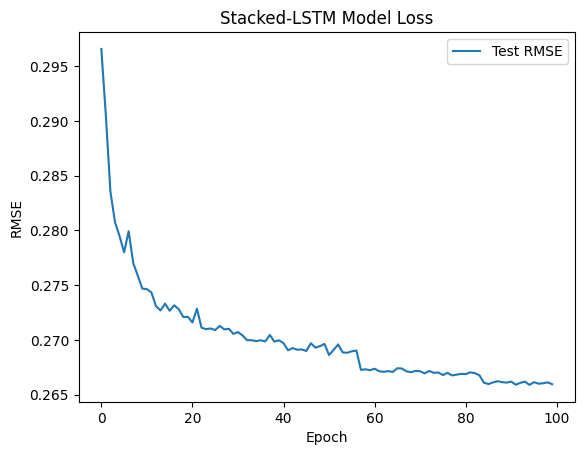

In [18]:
import matplotlib.pyplot as plt

# Plotting and saving Loss graph
plt.figure()
plt.plot(lstm_train_losses, label='Train Loss')
plt.plot(lstm_test_losses, label='Test Loss')
plt.title('Stacked-LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.savefig(os.path.join(main_directory, model_folder, 'lstm_model_MSE.png'))
plt.show()

plt.figure()
plt.plot(lstm_rmse, label='Test RMSE')
plt.title('Stacked-LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.savefig(os.path.join(main_directory, model_folder, 'lstm_model_RMSE.png'))
plt.show()

In [19]:
# Path for the CSV file
csv_file_path = os.path.join(main_directory, model_folder, 'lstm_model_results.csv')

# Writing metrics to CSV
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Train Loss', 'Test Loss', 'RMSE'])
    for epoch in range(len(lstm_train_losses)):
        writer.writerow([epoch + 1, lstm_train_losses[epoch], lstm_test_losses[epoch], lstm_rmse[epoch]])


In [20]:
import pickle

def loadScaler(variable):
    filename = 'scaler_' + str(variable) + '.pkl'
    with open(os.path.join(main_directory, scaler_folder, filename), 'rb') as file:
        return pickle.load(file)

scaler_folder = 'Scalers'
features = ['theta', 'v', 'r', 'ay', 'force', 'u','xu', 'xy']
# load scalers 
scalers = {variable: loadScaler(variable) for variable in features}
# load model
#model = LSTMModel(num_features=8, num_classes=7, hidden_size=100, num_layers=2).to(device)
#model.load_state_dict(torch.load(os.path.join(main_directory, model_folder, 'stacked_lstm_model_200.pth')))

#model = LSTMModel(num_features=8, num_classes=7, hidden_size=100, num_layers=2).to(device)
#model.load_state_dict(torch.load(os.path.join(main_directory, model_folder, 'lstm_model.pth')))

#model = CNNLSTMModel(num_features=8, num_classes=7, hidden_size=100, num_layers=2).to(device)
#model.load_state_dict(torch.load(os.path.join(main_directory, model_folder, 'cnn_lstm_model_200.pth')))

#model = CNNLSTMModel(num_features=8, num_classes=7, hidden_size=50, num_layers=2).to(device)
#model.load_state_dict(torch.load(os.path.join(main_directory, model_folder, 'cnn_lstm_model_100_Epochs.pth')))

model = LSTMModel(num_features=8, num_classes=7, hidden_size=50, num_layers=2).to(device)
model = nn.DataParallel(model)
#print(os.path.join(main_directory, model_folder, 'cnn_lstm_model_100.pth'))
model.load_state_dict(torch.load(os.path.join(main_directory, model_folder, 'lstm_model_100.pth')))

#print(X_data[0])
#print(Y_data[0])

<All keys matched successfully>

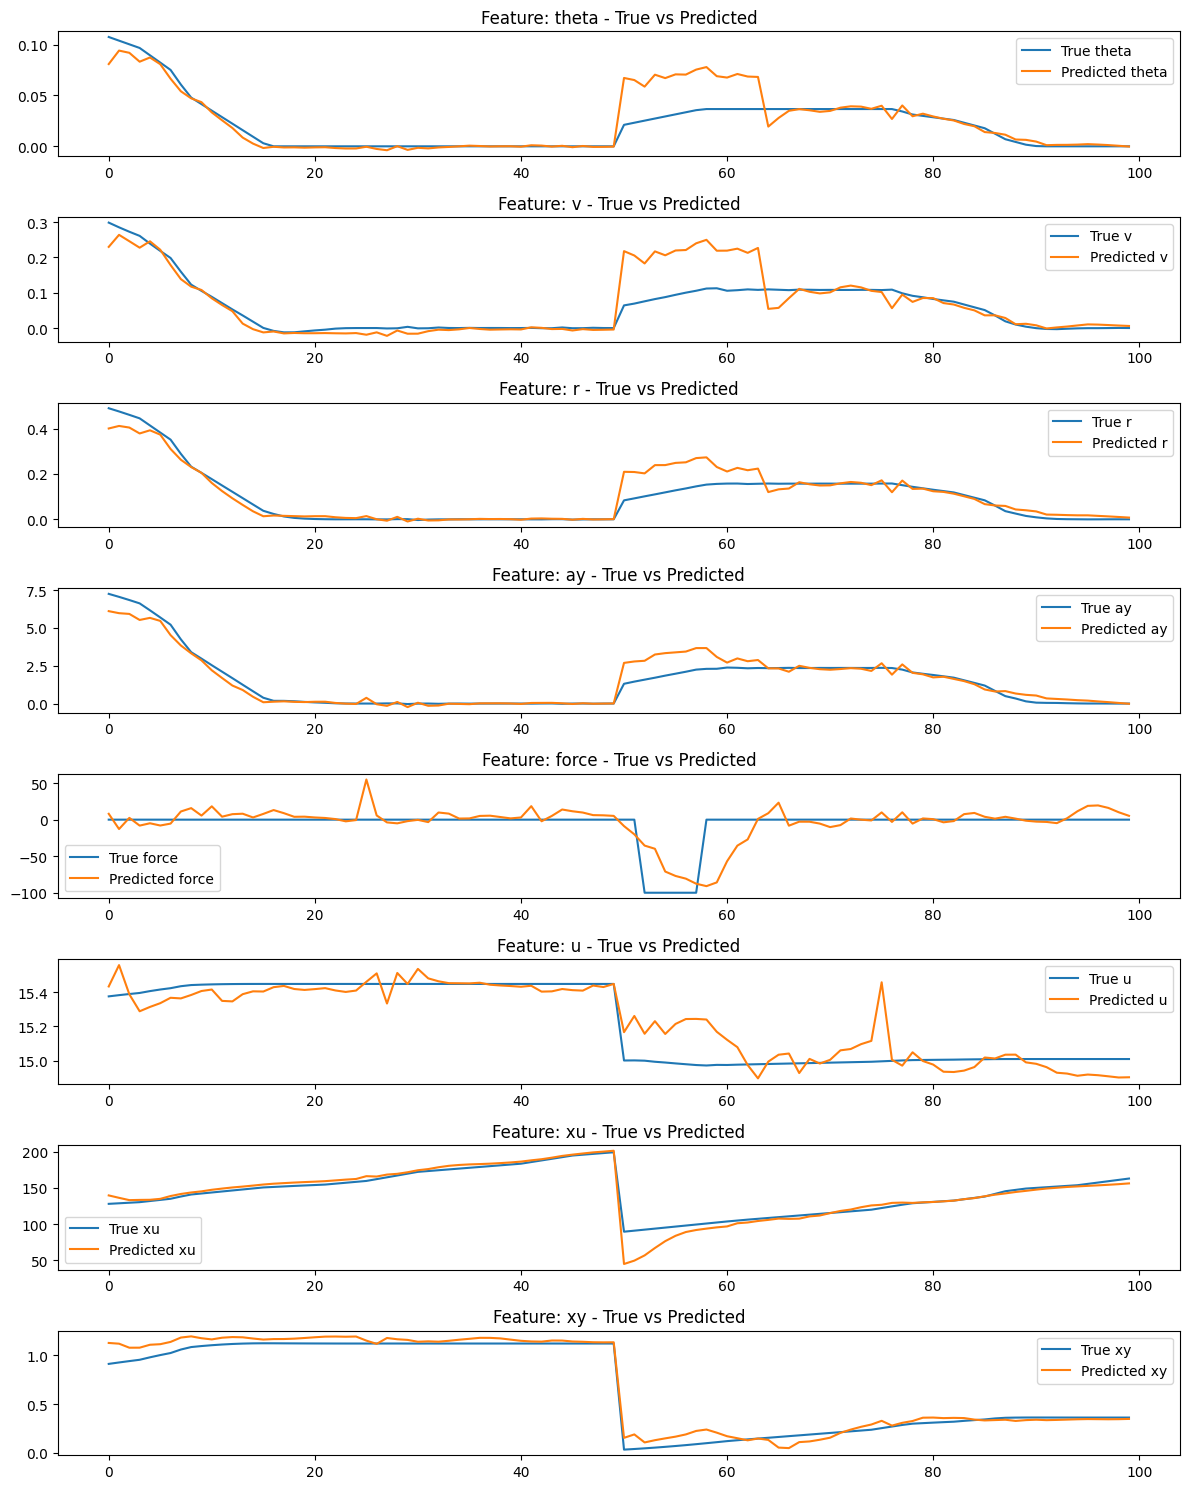

In [22]:
import matplotlib.pyplot as plt

# Select examples based on given indices
indices = [i for i in range(400, 500, 25)]
selected_X = X_tensor[indices]
selected_Y = Y_tensor[indices]
selected_labels = maneuver_labels_tensor[indices]

selected_X = selected_X.permute(0, 2, 1)
selected_Y = selected_Y.permute(0, 2, 1)

#model = model.cpu()
#selected_X = selected_X.cpu()
#selected_labels = selected_labels.cpu()
#selected_Y = selected_Y.cpu()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)  # Move the model to the specified device

# Also move the input data to the same device
selected_X = selected_X.to(device)
selected_labels = selected_labels.to(device)
selected_Y = selected_Y.to(device)

# Make predictions
with torch.no_grad():
    model.eval()
    predicted_Y = model(selected_X, selected_labels)
    
# Move the predictions to CPU for processing with NumPy
predicted_Y = predicted_Y.cpu()
selected_Y = selected_Y.cpu()

# Inverse scaling
inverse_scaled_predicted = []
inverse_scaled_true = []
for i, example in enumerate(predicted_Y):
    inverse_scaled_example = []
    for j, feature in enumerate(features):
        inverse_scaled_example.append(scalers[feature].inverse_transform(example[:, j].numpy().reshape(-1, 1)))
    inverse_scaled_predicted.append(np.hstack(inverse_scaled_example))
    inverse_scaled_true.append(np.hstack([scalers[feature].inverse_transform(selected_Y[i][:, j].numpy().reshape(-1, 1)) for j, feature in enumerate(features)]))

# Plotting
# Concatenate all sequences for each feature
concatenated_true = np.concatenate([inverse_scaled_true[i] for i in range(len(inverse_scaled_true))], axis=0)
concatenated_pred = np.concatenate([inverse_scaled_predicted[i] for i in range(len(inverse_scaled_predicted))], axis=0)

# Plotting
plt.figure(figsize=(12, 15))
for j in range(len(features)):
    plt.subplot(len(features), 1, j + 1)
    plt.plot(concatenated_true[:, j], label=f"True {features[j]}")
    plt.plot(concatenated_pred[:, j], label=f"Predicted {features[j]}")
    plt.legend()
    plt.title(f"Feature: {features[j]} - True vs Predicted")
plt.tight_layout()
plt.show()
